In [1]:
import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pickle
from networkx import MultiDiGraph

from analysis import citation_matrix_institutions
from group_affiliations import Paper, PaperAuthor, Affiliation
from group_affiliations import hardcoded_entries, define_type, mapping_entities

colors = {"node": dict(zip(range(1, 4), ["blue", "green", "red"])),
         "edge": {
             (1,1): "blue", (2,2): "green", (3,3): "red", (1,2): "cyan", (2,1): "cyan",
             (1,3): "purple", (3,1): "purple", (2,3): "brown", (3,2): "brown"}
         }

In [2]:
with open("./data/data.pkl", "rb") as f:
    data = pickle.load(f)

with open("./data/affiliation_type_raw.pkl", "rb") as f:
    file = pickle.load(f)
    idx = np.array(list(file.keys())).astype(int)
    descriptions = np.array(list(file.values()))

affiliation_group = []
affiliations = np.array([
    x.name for i, x in enumerate(data["affiliations"].values()) if i in idx
])

for i in range(len(idx)):
    affiliation_group.append(define_type(affiliations[i], descriptions[i]))
affiliation_group = np.array(affiliation_group)

In [3]:
# input entries that have been hardcoded (e.g. Intel --> 3)
for k, v in hardcoded_entries.items():
    affiliation_group[np.where(np.isin(idx, v))[0]] = k

for k, v in mapping_entities.items():
    print(f"{v.title()} in the top {len(idx)}: {(affiliation_group == k).sum()}")

University in the top 654: 525
Institute in the top 654: 69
Company in the top 654: 60


In [4]:
cit_inst = citation_matrix_institutions(data)
cit_sum = cit_inst.sum(axis=0)
cit_inst = cit_inst[idx][:, idx]
cit_sum = cit_sum[idx]

top_filt_idx = {}

for k in set(affiliation_group):
    f_idx = np.where(affiliation_group == k)[0]
    f_idx = f_idx[(-cit_sum[f_idx]).argsort()]
    top_filt_idx[k] = f_idx
total_filt_idx = (-cit_sum).argsort()

In [107]:
top_k = {1: 5, 2: 5, 3: 10}
top_k_idx = np.concatenate([v[:top_k[k]] for k, v in top_filt_idx.items()])
top_cit_inst = cit_inst[top_k_idx][:, top_k_idx]
top_cit_inst_n = 3.0*top_cit_inst/top_cit_inst.max()
#top_cit_inst_n = np.log(top_cit_inst+1)
#top_cit_inst_n = ((top_cit_inst_n - top_cit_inst_n.min())/(top_cit_inst_n.max() - top_cit_inst_n.min()))

size = cit_sum[top_k_idx]
size = 350*size/size.max()
#size = 300*np.log(size+1)/np.log(size+1).max()
node_labels = ['UC Berkeley','CMU','UoftT','Stanford','Univ. of Oxford','Max Planck Society','CAS','Inria','AI2','CIFAR','Google','Microsoft','Facebook','IBM','Huawei','Alcatel-Lucent','Adobe Systems','AT&T','Baidu','OpenAI',]

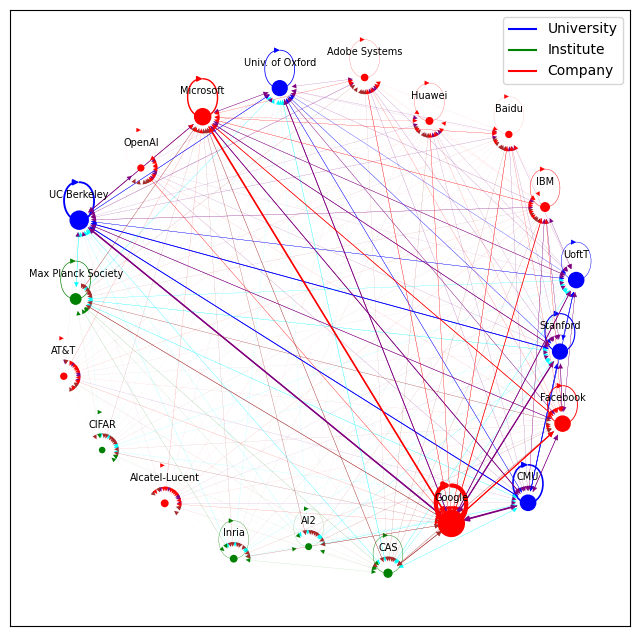

In [108]:
fig, ax = plt.subplots(1,1, figsize=(8, 8))


G = nx.MultiDiGraph()
for i in range(len(top_k_idx)):
    G.add_node(i)

for i, j in zip(*top_cit_inst.nonzero()):
    G.add_edge(i, j, weight=top_cit_inst_n[i, j])
    
pos = nx.spring_layout(G, 111)

nx.draw_networkx_nodes(G,
                       pos,
                       dict(zip(range(len(top_k_idx)), np.array(affiliations)[top_k_idx].tolist())),
                       node_color = [colors["node"][k] for k in affiliation_group[top_k_idx]],
                       node_size=size
)

for edge in G.edges(data='weight'):
    edge_color = colors["edge"][tuple(affiliation_group[top_k_idx[list(edge[:2])]])]
    nx.draw_networkx_edges(G, pos, edgelist=[edge], width=edge[2], alpha=1, arrowsize=8, edge_color=edge_color)

for v, k in mapping_entities.items():
    ax.plot([0],[0], color=colors["node"][v], label=k.title())

def nudge(pos, x_shift, y_shift):
    return {n:(x + x_shift, y + y_shift) for n,(x,y) in pos.items()}
pos_nodes = nudge(pos, 0, 0.1)                              # shift the layout
nx.draw_networkx_labels(G, pos=pos_nodes, labels=dict(zip(range(len(node_labels)), node_labels)), font_size=7)

plt.legend()

In [75]:
rank_idx = (-cit_sum[top_k_idx]).argsort()
rank = dict(zip(
    np.array(affiliations)[top_k_idx][rank_idx],
    cit_sum[top_k_idx][rank_idx].astype(int)
))
rank

{'Google': 47734,
 'University of California, Berkeley': 23016,
 'Microsoft': 18242,
 'Carnegie Mellon University': 16470,
 'University of Toronto': 16182,
 'Facebook': 16127,
 'Stanford University': 15547,
 'University of Oxford': 15458,
 'Max Planck Society': 7642,
 'IBM': 5134,
 'Chinese Academy of Sciences': 4359,
 'Huawei': 3054,
 'Alcatel-Lucent': 2956,
 'French Institute for Research in Computer Science and Automation': 2907,
 'Adobe Systems': 2720,
 'AT&T': 2533,
 'Baidu': 2495,
 'OpenAI': 2424,
 'Allen Institute for Artificial Intelligence': 2214,
 'Canadian Institute for Advanced Research': 1867}